# Test polynomials from FNFT

## Import

In [2]:
import sys
# adding signal_handling to the system path
sys.path.insert(0, '../signal_handling/')
sys.path.insert(0, '../nft_handling/')
sys.path.insert(0, '../pjt/')
sys.path.insert(0, '../root_finding/')


from FNFTpy import nsev#, nsev_poly
from FNFTpy import nsev_inverse, nsev_inverse_xi_wrapper
import numpy as np
import pandas as pd
import random
import timeit
from tqdm import tqdm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift

import matplotlib.pyplot as plt
import matplotlib

from importlib import reload

import ssfm
reload(ssfm)

import signal_generation as sg
reload(sg)

import nft_analyse as nft
reload(nft)

import test_signals
from pjt import pjt

from jenkins_traub import jenkins_traub


ImportError: cannot import name 'nsev_poly' from 'FNFTpy' (C:\ProgramData\Anaconda3\envs\tensorflow_2_9\lib\site-packages\FNFTpy\__init__.py)

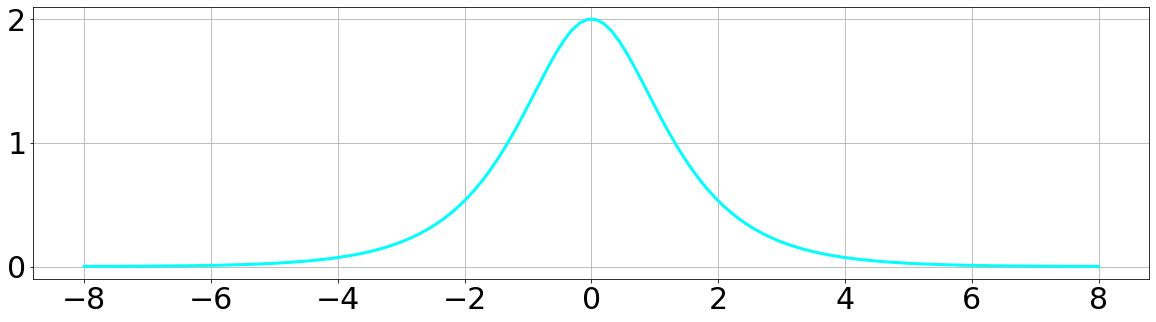

In [3]:
ampl = 2.0
chirp = 0.0

t_span = 16.0
n_t = 2 ** 7

dt = t_span / (n_t - 1)
t = np.array([i * dt - t_span / 2. for i in range(n_t)])

xi_span = np.pi / dt
n_xi = 2 ** 7
d_xi = xi_span / (n_xi - 1)
xi = np.array([i * d_xi - xi_span / 2. for i in range(n_xi)])

q, a_xi, b_xi, xi_discr, b_discr, r_discr, ad_discr = test_signals.get_sech(t, xi, a=ampl, c=chirp)

matplotlib.rcParams.update({'font.size': 30})
# color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan']
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(t, np.absolute(q), 'xkcd:cyan', linewidth=3)
axs.grid(True)

0.5 128 1 0 0.0 -16.0
<class 'numpy.ndarray'>
128 128


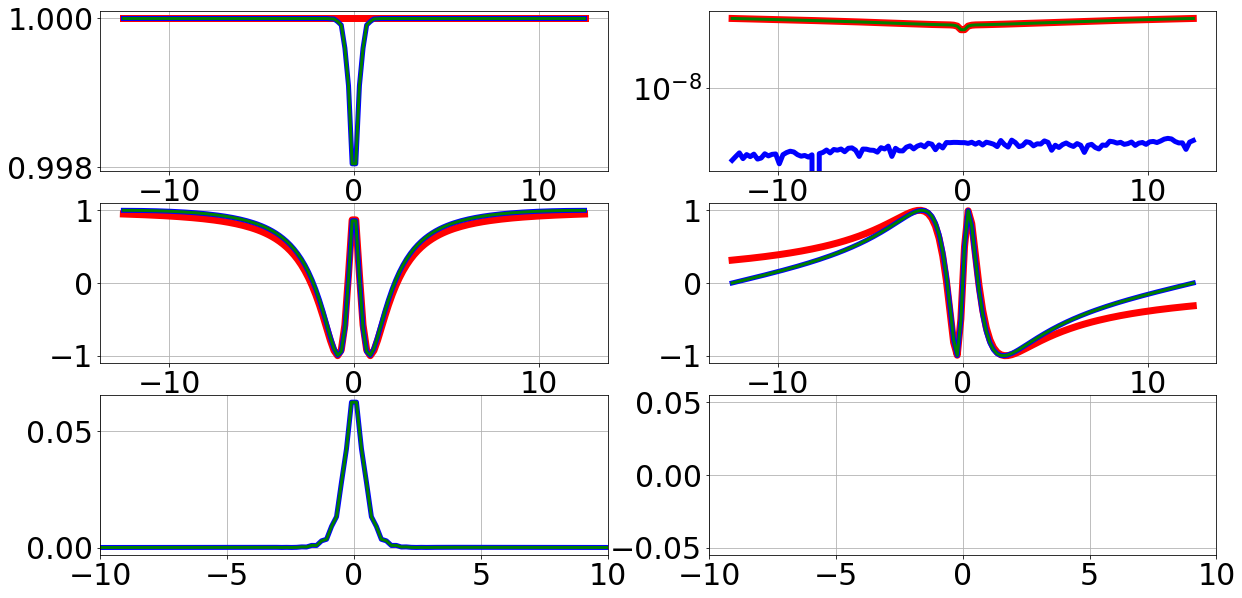

In [4]:
fnft_type = 0

res0 = nsev(q, t, xi[0], xi[-1], n_xi, dis=0, cst=1)
res = nsev(q, t, xi[0], xi[-1], n_xi, dis=fnft_type, cst=1)
a_fnft = res['cont_a']
b_fnft = res['cont_b']

res_poly = nsev_poly(q, t, dis=fnft_type)
a_coef = res_poly['coef_a']
b_coef = res_poly['coef_b']
ampl_scale = res_poly['ampl_scale']
deg = res_poly['deg']
deg1step = res_poly['deg1step']
deg1step_denom = res_poly['deg1step_denom']
phase_a = res_poly['phase_a']
phase_b = res_poly['phase_b']

print(ampl_scale, deg, deg1step, deg1step_denom, phase_a, phase_b)
print(type(a_coef))


# transform for spectral parameter z = e ^ (1j * xi * dt)
# z = np.exp(2j * xi / (deg1step - 2 * deg1step_denom) * dt)
z = np.exp(2j * xi / (deg1step - 2 * deg1step_denom) * dt)
# z_discr = np.exp(2j * xi_discr / (deg1step - 2 * deg1step_denom) * dt)

a_poly = np.polyval(ampl_scale * a_coef, z) * np.exp(1j * xi * phase_a)
b_poly = np.polyval(ampl_scale * b_coef, z) * np.exp(1j * xi * phase_b)
if fnft_type == 49 or fnft_type == 50:
    a_poly = a_poly * z ** (-2 * n_t)
    b_poly = b_poly * z ** (-2 * n_t)
    # a_poly = a_poly * np.exp(2j * xi / (deg1step - 2 * deg1step_denom) * dt * (-2 * n_t))
    # b_poly = b_poly * np.exp(2j * xi / (deg1step - 2 * deg1step_denom) * dt * (-2 * n_t))
print(np.size(a_poly), np.size(a_xi))

matplotlib.rcParams.update({'font.size': 30})
color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan']
fig, axs = plt.subplots(3, 2, figsize=(20, 10))
axs[0][0].plot(xi, np.absolute(a_xi), color[0], linewidth=7)
axs[0][0].plot(xi, np.absolute(a_poly), color[1], linewidth=5)
axs[0][0].plot(xi, np.absolute(a_fnft), color[2], linewidth=3)
axs[0][0].grid(True)

axs[0][1].plot(xi, np.absolute(a_xi - a_poly), color[0], linewidth=7)
axs[0][1].plot(xi, np.absolute(a_fnft - a_poly), color[1], linewidth=5)
axs[0][1].plot(xi, np.absolute(a_xi - a_fnft), color[2], linewidth=3)
axs[0][1].set_yscale('log')
axs[0][1].grid(True)

axs[1][0].plot(xi, np.real(a_xi), color[0], linewidth=7)
axs[1][0].plot(xi, np.real(a_poly), color[1], linewidth=5)
axs[1][0].plot(xi, np.real(a_fnft), color[2], linewidth=3)
axs[1][0].grid(True)

axs[1][1].plot(xi, np.imag(a_xi), color[0], linewidth=7)
axs[1][1].plot(xi, np.imag(a_poly), color[1], linewidth=5)
axs[1][1].plot(xi, np.imag(a_fnft), color[2], linewidth=3)
axs[1][1].grid(True)

axs[2][0].plot(xi, np.absolute(b_xi / a_xi), color[0], linewidth=7)
axs[2][0].plot(xi, np.absolute(b_poly / a_poly), color[1], linewidth=5)
axs[2][0].plot(xi, np.absolute(b_fnft / a_fnft), color[2], linewidth=3)
axs[2][0].set_xlim(-10, 10)
axs[2][0].grid(True)

axs[2][1].plot(xi, np.absolute(b_xi / a_xi - b_poly / a_poly), color[0], linewidth=7)
# axs[2][1].plot(xi, np.absolute(b_fnft / a_fnft - b_poly / a_poly), color[1], linewidth=5)
axs[2][1].plot(xi, np.absolute(b_xi / a_xi - b_fnft / a_fnft), color[2], linewidth=3)
axs[2][1].set_xlim(-10, 10)
axs[2][1].grid(True)



In [5]:
print(np.mean(np.absolute(b_poly - b_xi)))
print(np.mean(np.absolute(b_fnft - b_xi)))
print(np.mean(np.absolute(b_poly - b_fnft)))
print(np.mean(np.absolute(a_poly - a_xi)))
print(np.mean(np.absolute(a_fnft - a_xi)))
print(np.mean(np.absolute(a_poly - a_fnft)))
print(b_xi)

nan
nan
1.7351362839731394e-16
0.1600975917921431
0.160097591792143
6.306307320194922e-15
[nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+na

In [5]:
# disc_spec = np.array(pjt(n_t, q, t[0], t[-1] + (t[-1] - t[0]) / n_t, 0, np.zeros(1, dtype=complex), omp_num_threads=8))
disc_spec = np.array(pjt(n_t, q, t[0], t[-1] + (t[-1] - t[0]) / n_t, 0, np.zeros(1, dtype=complex), omp_num_threads=8))
print(disc_spec)
print(res['bound_states'])
print(res0['bound_states'])

test_type='es4'
a_d_pjt, _ = nft.get_scattering_array(q, t, disc_spec, type=test_type)
a_d_fnft, _ = nft.get_scattering_array(q, t, res['bound_states'], type=test_type)
a_d_fnft0, _ = nft.get_scattering_array(q, t, res0['bound_states'], type=test_type)
print(np.absolute(a_d_pjt))
print(np.absolute(a_d_fnft))
print(np.absolute(a_d_fnft0))

[-3.38963670e-32+1.49999237j -1.83670992e-39+0.49997627j]
[-1.73729706e-50+0.4999773j   5.25486924e-46+1.49980322j]
[2.73691106e-48+0.4999773j  2.18952885e-46+1.49980322j]
[3.15275695e-05 5.16206159e-07]
[2.52548571e-15 3.22415525e-16]
[2.52905462e-15 3.22415525e-16]


In [59]:
xi_test = res0['bound_states']
# xi_test = np.array([0.5j, 1.5j])
print(xi_test)
z_test = np.exp(2j * xi_test / (deg1step - 2 * deg1step_denom) * dt)
a_in_z_test = np.polyval(a_coef, z_test)
print(a_in_z_test)

[-6.84227766e-49+0.4999773j   1.40129846e-45+1.49980322j]
[-0.00519068+3.83725045e-16j  0.00167468-7.60346737e-17j]


In [190]:
d_xi_for_init = xi_span / (len(a_coef) - 1 - 1)
xi_for_init = np.array([k * d_xi_for_init - xi_span / 2. for k in range(len(a_coef) - 1)])
init_approx = np.exp(2j * xi_for_init / (deg1step - 2 * deg1step_denom) * dt)
roots = nft.aberth_ehrlich(a_coef, max_iter=11, tol=1e-10, check_tol=False, initial=init_approx)


# z = np.exp(2j * xi / (deg1step - 2 * deg1step_denom) * dt)

roots_xi = 1.0 / (2j / (deg1step - 2 * deg1step_denom) * dt) * np.log(roots)

# print(roots)
poly_in_roots = np.polyval(a_coef, roots)
print(np.max(np.absolute(poly_in_roots)))

7.652946580002887


In [223]:
roots_next = nft.aberth_ehrlich(a_coef, max_iter=13, tol=1e-10, check_tol=False, initial=init_approx)
print(np.max(np.absolute(np.polyval(a_coef, roots_next))))
roots_xi_next = 1.0 / (2j / (deg1step - 2 * deg1step_denom) * dt) * np.log(roots_next)

2.144652358729824e+117


In [6]:
jt_roots = jenkins_traub(a_coef, 1e-12, 1000)
# print(list(map('{:.2f}'.format, np.roots(a_coef))))

In [7]:
for jt_root in jt_roots:
    print(jt_root)

Done with Stage 1 after 4 iterations.
Done with Stage 2 after 2 iterations.
Done with Stage 3 after 4 iterations.
(0.6888255429229161-1.6953950475079921e-16j)
Done with Stage 1 after 4 iterations.
Done with Stage 2 after 2 iterations.
Done with Stage 3 after 4 iterations.
(0.8862125400187038+2.0711897425761433e-17j)
Done with Stage 1 after 4 iterations.
Done with Stage 2 after 2 iterations.
Done with Stage 3 after 13 iterations.
(0.8038526780039006+0.8157422566045547j)
Done with Stage 1 after 4 iterations.
Done with Stage 2 after 2 iterations.
Done with Stage 3 after 10 iterations.
(1.0320504947072937+0.48292856802980794j)
Done with Stage 1 after 4 iterations.
Done with Stage 2 after 4 iterations.
Done with Stage 3 after 7 iterations.
(1.1185250569968521-0.1948092573954212j)
Done with Stage 1 after 4 iterations.
Done with Stage 2 after 2 iterations.
Done with Stage 3 after 5 iterations.
(1.1322866569003116+0.06936644414566846j)
Done with Stage 1 after 4 iterations.
Done with Stage 2 af

KeyboardInterrupt: 

In [161]:
# print(len(roots), 2 ** 7)
print(roots_xi)
print(poly_in_roots)
# np.random.random()

[-1.24681958e+01-2.32692746e-19j -1.23786440e+01-6.01103273e-01j
 -1.20972793e+01-6.20121722e-01j -1.18432988e+01-6.07232448e-01j
 -1.15795703e+01-6.13382558e-01j  1.03347002e+01+1.69985242e+00j
 -1.13939173e+01-5.80861281e-01j -1.11965664e+01-5.87261602e-01j
 -1.10013356e+01-5.86753854e-01j -1.08057131e+01-5.86445044e-01j
 -1.06100966e+01-5.86127046e-01j -1.04144755e+01-5.85770827e-01j
 -1.02188447e+01-5.85376438e-01j -1.00232025e+01-5.84944275e-01j
 -9.82754795e+00-5.84474076e-01j -9.63187983e+00-5.83965361e-01j
 -9.43619682e+00-5.83417570e-01j -9.24049750e+00-5.82830097e-01j
 -9.04478039e+00-5.82202281e-01j -8.84904385e+00-5.81533412e-01j
 -8.65328619e+00-5.80822721e-01j -8.45750552e+00-5.80069381e-01j
 -8.26169987e+00-5.79272500e-01j -8.06586705e+00-5.78431122e-01j
 -7.87000473e+00-5.77544216e-01j -7.67411036e+00-5.76610679e-01j
 -7.47818114e+00-5.75629329e-01j -7.28221403e+00-5.74598898e-01j
 -7.08620567e+00-5.73518032e-01j -6.89015239e+00-5.72385281e-01j
 -6.69405010e+00-5.711990

In [63]:
xi_span_test = np.pi / dt
n_xi_test = 2 ** 7
d_xi_test = xi_span_test / (n_xi_test - 1)
xi_real_test = np.array([i * d_xi_test - xi_span_test / 2. for i in range(n_xi_test)])

In [139]:
xi_span_test

50.06913291658733

In [116]:
initial = np.power(0.4+0.9j, np.arange(len(a_coef) - 1))
xi_initial = 1.0 / (2j / (deg1step - 2 * deg1step_denom) * dt) * np.log(initial)

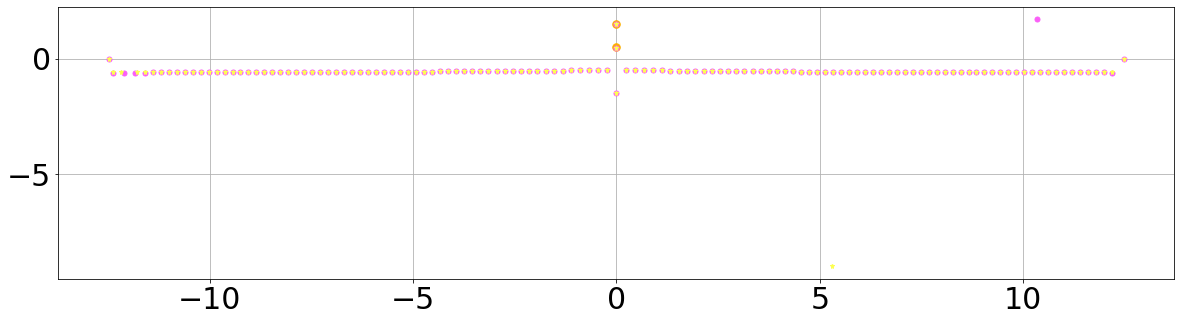

In [224]:
matplotlib.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(np.real(xi_test), np.imag(xi_test), 'xkcd:yellow orange', linewidth=0, marker='.', markersize=15)
axs.plot(np.real(roots_xi), np.imag(roots_xi), 'xkcd:light magenta', linewidth=0, marker='.', markersize=10)
axs.plot(np.real(roots_xi_next), np.imag(roots_xi_next), 'xkcd:lemon', linewidth=0, marker='*', markersize=5)
# axs.plot(np.real(xi_real_test), np.imag(xi_real_test), 'xkcd:bluish purple', linewidth=0, marker='.', markersize=5)

# axs.plot(np.real(initial), np.imag(initial), 'xkcd:light magenta', linewidth=0, marker='.', markersize=5)

# axs.plot(np.real(roots), np.imag(roots), 'xkcd:lime', linewidth=0, marker='.', markersize=10)
# axs.plot(np.real(roots_next), np.imag(roots_next), 'xkcd:bluish purple', linewidth=0, marker='d', markersize=4)
# axs.plot(np.real(z_test), np.imag(z_test), 'xkcd:cyan', linewidth=0, marker='.', markersize=10)
# axs.plot(np.real(poly_in_roots), np.imag(poly_in_roots), 'xkcd:cyan', linewidth=0, marker='.', markersize=10)

# axs.set_ylim(0, 2)
axs.grid(True)

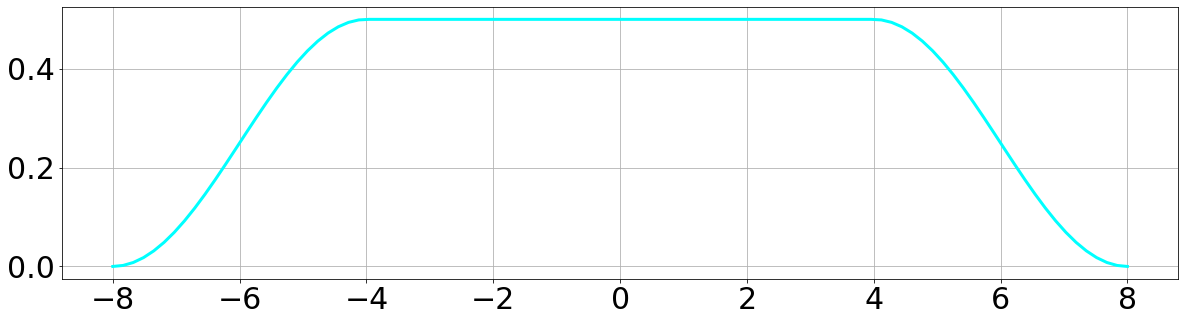

In [11]:
xi_contour = nft.get_raised_contour(0.5, 16, 100)

matplotlib.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(np.real(xi_contour), np.imag(xi_contour), 'xkcd:cyan', linewidth=3)
axs.grid(True)

In [5]:
a = np.array([1 + 2.5j, 2 - 1j, 3 - 2j, 3 - 3j, 3 + 5j])
a_sort = -1j * np.sort_complex(1j * a)

print(a_sort)
print(a_sort[:3])
print(a_sort[1:4])
print(np.imag(a_sort[:3]) - np.imag(a_sort[1:4]))

print(np.where(a == 3 - 2j)[0][0])

[3.+5.j  1.+2.5j 2.-1.j  3.-2.j  3.-3.j ]
[3.+5.j  1.+2.5j 2.-1.j ]
[1.+2.5j 2.-1.j  3.-2.j ]
[2.5 3.5 1. ]
2


In [6]:
# print(nft.test_nft.__doc__)




    Test function for NFT.
    It calculates and draws nonlinear spectrum for sech shape and compare it with theoretical values
    sech = a * sech(t) ^ (1+ 1j * c)
    Than it shows order of calculation methods

    Args:
        ampl: amplitude for sech shape
        chirp: chirp parameter
        t_span: length of full region in t domain, t in [-t_span/2; t_span/2]
        n_t: number of discretisation points in t domain
        n_grid: number of different n_xi

    Optional Args:
        type: type of calculation, default = 'bo' -- Bofetta-Osborne

                - bo -- Bofetta-Osborne
                - bod -- Bofetta-Osborne with da / dxi
                - tes4 -- TES4
                - tes4d -- TES4 with da / dxi
                - es4 -- ES4
                - es4d -- ES4 with da / dxi

        fnft_type: type of calculation for FNFT library, default = 11
        plot_flag: 1 - plots function(a - a_theory) and same for b, 2 - plots function(a - a_theory) and same for b
        